In [1]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import numpy as np
import webbrowser  
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

In [2]:
df = pd.read_csv("all_scps_final.csv")
df.head()

,Number,Tags,Sub-Objects,Pos Ratings,All Ratings,Word Count,Safe,Euclid,Keter,Thaumiel,...,Neutral,D-Class,Containment Breach,Addendum,Task Force,O5 Council,Agent,[EXPUNGED],[REDACTED],Blacked Out
0,2.0,alive euclid featured scp structure transfigur...,None,1832.0,2206.0,857.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,3.0,alive biological computer director-moose eucli...,1 2,824.0,1056.0,1789.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
2,4.0,euclid mind-affecting portal scp spacetime str...,1 2 7 12 13 14,1154.0,1340.0,1452.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,5.0,adaptive safe scp,None,710.0,1268.0,373.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,liquid location medical rewrite safe scp self-...,None,686.0,1212.0,491.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


## Visualizations of the Data

In [3]:
def make_wordcloud(doc):
  '''makes a word cloud given a document
    Args:
        doc (str): a single document (one string)
    Return:
        cloud (WordCloud): a WordCloud object
  '''
  cloud = wordcloud.WordCloud()
  cloud.generate_from_text(doc)
  return cloud

In [16]:
# make word cloud out of all the tags
df = pd.read_csv("all_scps_final.csv")
tags = " ".join(df["Tags"])

# scp is a tag for basically every one, remove so it isnt cluttering
tags = tags.replace("scp", "")
cloud = wordcloud.WordCloud(width=2000, height=1000)
plt.figure(dpi=200)
cloud.generate_from_text(tags)
cloud.to_image()

# save cloud
cloud.to_file("Wordcloud_of_tags.png")

<Figure size 1200x800 with 0 Axes>

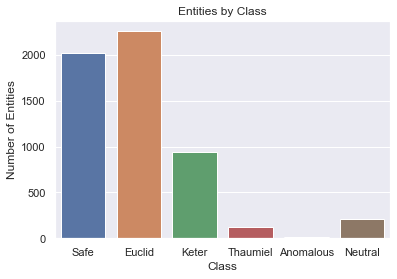

In [5]:
# count how many of each type there are
import matplotlib.pyplot as plt

# set classes
classes = ["Safe", "Euclid", "Keter", "Thaumiel", "Anomalous", "Neutral"]

# make empty list to hold amount in each class
amount = []

# for each class, count the amount of scps
for i in classes:
    class_ = df[df[i] == 1][i].count()
    amount.append(class_)

# plot results
sns.set()
sns.barplot(x = classes, y = amount)
plt.title("Entities by Class")
plt.ylabel("Number of Entities")
plt.xlabel("Class")

# save plot
plt.savefig("Classes.png")

## Pipeline Overview

#### Recommendation Algorithmn
- `my_tokenizer()`
    - a tokenizer that keeps single characters
- `turn_data_into_arrays()`
    - turns original dataframe into a dataframe with arrays
- `get_similarities()`
    - gets cosin similarities
- `recommend_scp()`
    - recommends scps based on inputted scp

### Cosine Similarity for SCP Article Recommendation
Cosine similarity was chosen to make a recommendation algorithmn for new SCP articles. Cosine similarty was chosen so the tags and objects could be incorporated into the recommendation. By finding the cosine similarity between different SCP articles, we can recommend similar articles. This could be useful to implement on the website to recommend similar articles to readers. 

In [6]:
def my_tokenizer(text):
    '''tokenizer that keeps single character
    Args:
        text (str): text to be tokenized
    Return:
        re.splot("\\s+", text) (str): good text
    '''
    # create a space between special characters 
    text=re.sub("(\\W)"," \\1 ",text)
    # split based on whitespace
    return re.split("\\s+",text)

In [7]:
def turn_data_into_arrays(df):
    ''' turns the scp dataframe into a dataframe with arrays representing the tags, objects, and other values for each scp
    Args:
        df (dataframe): dataframe containing all scps with original data
    Return:
        df_array (dataframe): dataframe containing all scps with data in arrays comparible by cosine similarity    
    '''
    # vectorize the Tags and Sub-Objects columns, save them as arrays
    vectorizer = CountVectorizer(tokenizer = my_tokenizer)
    objects_array = vectorizer.fit_transform(df["Sub-Objects"])
    objects_array = objects_array.toarray()

    vectorizer = CountVectorizer()
    tags_array = vectorizer.fit_transform(df["Tags"])
    tags_array = tags_array.toarray()

    # make the arrays into lists and add them into their own columns in a new dataframe
    df_array = pd.DataFrame()
    df_array["Number"] = df["Number"]
    df_array = df_array.set_index("Number")
    df_array["Tags Array"] = list(tags_array)
    df_array["Objects Array"] = list(objects_array)

    # turn the other x features in the dataframe into an array
    # all x features that need to be normalized
    x_to_normalize = ["Pos Ratings", "All Ratings", "Word Count"] 

    # normalize the x features in new dataframe
    df_norm = pd.DataFrame()
    for feat in x_to_normalize:
        df_norm[feat] = df[feat] / df[feat].std()
    x_feats = ["Safe", "Euclid", "Keter", "Thaumiel", "Anomalous", "Neutral", "D-Class", "Containment Breach", 
               "Addendum", "Task Force", "O5 Council", "Agent", "[EXPUNGED]", "[REDACTED]", "Blacked Out"]
    # add the rest of the x features into the dataframe
    for feat in x_feats:
        df_norm[feat] = df[feat]
    
    # extract data into numpy format
    num_array = df_norm.values

    # add numpy array to df_array
    df_array["Num Array"] = list(num_array)
    
    return(df_array)

In [8]:
def get_similarities(scp, df_array):
    ''' # gets cosin similarities between given scp and all other scps, returns scps with closest similarities
    Args:
        scp (int): the number of the scp you want similar ones to
        df_array (dataframe): a dataframe with arrays representing the tags, subobjects, and other values from the original 
                                dataframe containing all scps
    Returns:
        similarities (dataframe): the similarity scores for each scp to the given scp
    '''
    # get vectors for the given scp
    tag_vec = df_array.loc[scp]["Tags Array"]
    obj_vec = df_array.loc[scp]["Objects Array"]
    num_vec = df_array.loc[scp]["Num Array"]
   
    # get similarity to the given scp for each scp in the dataframe, store in dataframe with scp number
    # create dataframe with a column as the scp number
    similarities = pd.DataFrame(columns = ["Number", "Similarity"])
    
    # for each scp, calculate the similarity score and put into Series
    for idx, row in df_array.iterrows():
       # get vectors for current scp
        tag2_vec = df_array.loc[idx]["Tags Array"]
        obj2_vec = df_array.loc[idx]["Objects Array"]
        num2_vec = df_array.loc[idx]["Num Array"]
        
        # calculate similarities for given scp and each scp
        tag_sim = cosine_similarity(tag_vec.reshape(1, -1), tag2_vec.reshape(1, -1))
        obj_sim = cosine_similarity(obj_vec.reshape(1, -1), obj2_vec.reshape(1, -1))
        num_sim = cosine_similarity(num_vec.reshape(1, -1), num2_vec.reshape(1, -1))
        
        # calculate overall similarity by adding
        # weight the factors as desired- objects are worth less, tags are worth a lot
        overall_sim = (2*tag_sim) + (0.5*obj_sim) + (0.75*num_sim)
        overall_sim = round(overall_sim[0][0], 2)
        
        # add similarites together and put into dataframe
        similarities = similarities.append({"Number" : idx, "Similarity": overall_sim}, ignore_index=True)
    
    # sort the similarites descending
    similarities.sort_values(by=['Similarity'], ascending = [False], inplace=True)
    
    return(similarities)

In [9]:
def recommend_scp(scp, df_array, df_scp, num_recs = 5, open_first = True):
    '''recommends a certain number of scps based on a given scp, displays their info in table and opens first recommendation
    Args:
        scp (int): number of scp
        df_array (dataframe): dataframe with arrays representing the tags, subobjects, and other values from the original 
                                dataframe containing all scps
        df_scp (dataframe): the original dataframe containing all scps
        num_recs (int): the number of recommendations to return
        open_first (boolean): whether or not to automatically open a tab for the first recommendation
    Returns:
        df_recs (dataframe): a dataframe with info, including links and similarity score, for the top similar scps
    
    '''
    # possibly put part in for what to do if scp not in the array
    
    # get the similarities
    similarities = get_similarities(scp, df_array)
    
    # get top (num_recs) in the similarities
    recs = list(similarities.iloc[0:num_recs + 1]["Number"])
    
    # create links to the top (rec) similar ones
    links = []
    for i in recs:
        # make sure scp number is in proper format for link
        # turn float into int and string
        i = str(int(i))
        # if the number is less than 3 numbers long, must add zeros in front
        while len(i) < 3:
            i = '0' + i   
            
        # create link  
        link = f'https://scp-wiki.wikidot.com/scp-{i}'
        links.append(link)
        
    # create new dataframe with the top recommended scps
    df_recs = pd.DataFrame()
    for i in recs:
        df_recs = df_recs.append(df_scp.loc[df["Number"] == i])
    
    # add links as a row in the dataframe
    df_recs["Link"] = links
    
    # add the similarity score to the dataframe, set similarity score of original to say "original"
    sim_score = list(similarities.iloc[0:num_recs + 1]["Similarity"])
    sim_score[0] = "Original"
    df_recs["Similarity Score"] = sim_score
    
    
    # open the top recommendation if open_first = True
    if open_first == True:
        webbrowser.open_new_tab(links[1])
        
    # make Number the index, add link and similarity score to the front of the dataframe
    df_recs = df_recs.set_index("Number")
    cols_to_move = ["Similarity Score", "Link"]
    df_recs = df_recs[cols_to_move + [x for x in df_recs.columns if x not in cols_to_move]]
    
    # return the top recommendations
    return(df_recs)

In [10]:
# turn the scp dataframe into array for the recommendation function
df_array = turn_data_into_arrays(df)

In [11]:
# check how long it takes the recommendation function to run
startTime = time.time()

# run recommendation function
og_scp = 5167
num_recs = 10
recs = recommend_scp(og_scp, df_array, df, num_recs)

# print function run time
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

# print scp recommendations
recs

Execution time in seconds: 11.013660907745361


,Similarity Score,Link,Tags,Sub-Objects,Pos Ratings,All Ratings,Word Count,Safe,Euclid,Keter,...,Neutral,D-Class,Containment Breach,Addendum,Task Force,O5 Council,Agent,[EXPUNGED],[REDACTED],Blacked Out
Number,,,,,,,,,,,,,,,,,,,,,
5167.0,Original,https://scp-wiki.wikidot.com/scp-5167,cognitohazard featured game keter mind-affecti...,None,299.0,1071.0,815.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1504.0,2.33,https://scp-wiki.wikidot.com/scp-1504,alive humanoid keter memetic meta mind-affecti...,None,997.0,1057.0,785.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4093.0,2.3,https://scp-wiki.wikidot.com/scp-4093,keter mind-affecting scp uncontained,None,108.0,128.0,775.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
35.0,2.25,https://scp-wiki.wikidot.com/scp-035,clothing cognitohazard ectoentropic keter mind...,None,1816.0,2036.0,1841.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2055.0,2.25,https://scp-wiki.wikidot.com/scp-2055,keter memory-affecting mind-affecting scp unco...,None,266.0,284.0,1568.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
953.0,2.24,https://scp-wiki.wikidot.com/scp-953,animal humanoid keter metamorphic mind-affecti...,None,541.0,791.0,1352.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1659.0,2.2,https://scp-wiki.wikidot.com/scp-1659,alive concept humanoid keter knowledge mind-af...,None,431.0,443.0,1796.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
53.0,2.15,https://scp-wiki.wikidot.com/scp-053,alive cognitohazard euclid humanoid mind-affec...,None,907.0,1131.0,447.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949.0,2.14,https://scp-wiki.wikidot.com/scp-3949,cognitohazard euclid featured knowledge memory...,None,490.0,556.0,585.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Results
It's a bit difficult to determine how well the recommendation algorithmn does with such a complex job. After several tests with different articles, the algorthimn appears to sucessfully recommend articles with similar themes. Testing the algorthimn on others outside the project also found success, and they enjoyed the recommended articles. 

Some examples of results:
SCP-1509 was put in to find a similar one.
Returned SCP-3118.
1509 is a knife that, when someone is cut with, ants come out of the wound.
3118 is gun that, when fired at someone's head, a lunch that the person once ate spontaneously appears. 

Another is https://scp-wiki.wikidot.com/scp-3126.
It returned https://scp-wiki.wikidot.com/scp-706.
3126 is a woman whose skin turns to iron when she is near a strong magnet.
706 is a girl who had porcelain skin.

Another is https://scp-wiki.wikidot.com/scp-1336. It returned https://scp-wiki.wikidot.com/scp-1161. 1336 is a sheet of paper whose contents constantly shift and occasionally form a picture of the structure of a new organic compound. 1161 is a book that, every day, contains different how-to instructions for a different random task. 